In [1]:
!pip install h5py

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import numpy as np
import math
import h5py
import random

In [29]:
labels_df = pd.read_csv("/content/sample_data/code15_chagas_labels.csv")

records = []

# Define the lead names in the order stored in the HDF5 file.
lead_names = ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF',
              'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Open the HDF5 file.
with h5py.File("/content/sample_data/exams_part0.hdf5", "r") as f:
    # Load the exam ids (assumed small enough to load into memory)
    exam_ids_hdf5 = f['exam_id'][:]  # shape: (N,)
    # Build a mapping from exam_id (converted to string) to its index.
    exam_id_to_index = {str(eid): idx for idx, eid in enumerate(exam_ids_hdf5)}

    # Access the tracings dataset without converting the whole thing to a NumPy array.
    tracings = f['tracings']  # shape: (N, 4096, 12)

    # Process each exam_id from the CSV.
    for _, row in labels_df.iterrows():
        exam_id = str(row['exam_id'])
        chagas_val = row['chagas']

        # Ensure the exam_id exists in the HDF5 file.
        if exam_id in exam_id_to_index:
            index = exam_id_to_index[exam_id]
            # Read only the required chunk for this exam_id.
            ecg_data = tracings[index, :, :]  # shape: (4096, 12)

            # Create a record for the DataFrame.
            record = {"exam_id": exam_id, "chagas": chagas_val}
            # For each lead, extract the corresponding signal and trim leading/trailing zeros.
            for j, lead in enumerate(lead_names):
                signal = ecg_data[:, j]
                # Find indices of non-zero elements.
                nonzero_indices = np.nonzero(signal)[0]
                if nonzero_indices.size > 0:
                    start = nonzero_indices[0]
                    end = nonzero_indices[-1] + 1  # +1 to include the last non-zero element.
                    trimmed_signal = signal[start:end]
                else:
                    # If the signal is all zeros, leave it unchanged.
                    trimmed_signal = signal
                record[lead] = trimmed_signal

            records.append(record)

# Construct a pandas DataFrame from the collected records.
df = pd.DataFrame(records)

# --- Standardize each ECG signal array for each lead ---
# for idx, row in df.iterrows():
#     for lead in lead_names:
#         signal = row[lead]
#         # Compute the mean and standard deviation of the signal.
#         mean_val = np.mean(signal)
#         std_val = np.std(signal)
#         # Avoid division by zero.
#         if std_val != 0:
#             standardized_signal = (signal - mean_val) / std_val
#         else:
#             standardized_signal = signal - mean_val
#         # Update the DataFrame with the standardized signal.
#         df.at[idx, lead] = standardized_signal

# Example: print the first row to see the standardized arrays.
print(df.head())

   exam_id  chagas                                                 DI  \
0  3000862   False  [2.4625041, 2.6512797, 2.2965233, 2.5552232, 2...   
1  2903368   False  [-0.09771842, -0.114296556, -0.05233861, -0.01...   
2  2891944   False  [0.04885921, 0.09299803, 0.048911728, 0.003107...   
3  2872920   False  [0.019543683, 0.004188288, -0.00091002416, -0....   
4  4243597   False  [2.8125315, 2.7956874, 2.7961586, 2.8219056, 2...   

                                                 DII  \
0  [-3.9966831, -4.3118763, -3.7316463, -4.137255...   
1  [-0.068402894, -0.10931933, 0.0883364, 0.28733...   
2  [0.12703393, 0.16206351, -0.07298482, -0.25317...   
3  [0.068402894, 0.088374145, 0.026369374, 0.0638...   
4  [-1.0975733, -1.1380206, -1.174241, -1.1905475...   

                                                DIII  \
0  [-6.459187, -6.9631557, -6.0281696, -6.692478,...   
1  [0.029315524, 0.22461408, 0.29533225, 0.257909...   
2  [0.07817473, -0.15057138, -0.2765538, -0.21380...   


In [45]:
def sliding_average(arr, n):
    """
    Compute the sliding average of an array with a specified window size.

    Parameters:
    arr (array-like): Input array of floats.
    n (int): Window size for the sliding average.

    Returns:
    numpy.ndarray: Array of sliding averages.
    """
    if n <= 0:
        raise ValueError("Window size n must be positive.")
    if n > len(arr):
        raise ValueError("Window size n must not be larger than the array length.")

    # Use numpy's cumsum to compute the cumulative sum
    cumsum = np.cumsum(np.insert(arr, 0, 0))
    # Calculate the moving average using the cumulative sum
    moving_avg = (cumsum[n:] - cumsum[:-n]) / float(n)

    return moving_avg

def compute_sliding_average(signal, window_size):
    """
    Compute the sliding average of a 1D array with a specified window size.

    Parameters:
    signal (numpy.ndarray): Input array of ECG readings.
    window_size (int): Window size for the sliding average.

    Returns:
    numpy.ndarray: Array of sliding averages.
    """
    if window_size <= 0:
        raise ValueError("Window size must be positive.")
    if window_size > len(signal):
        raise ValueError("Window size must not be larger than the signal length.")

    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

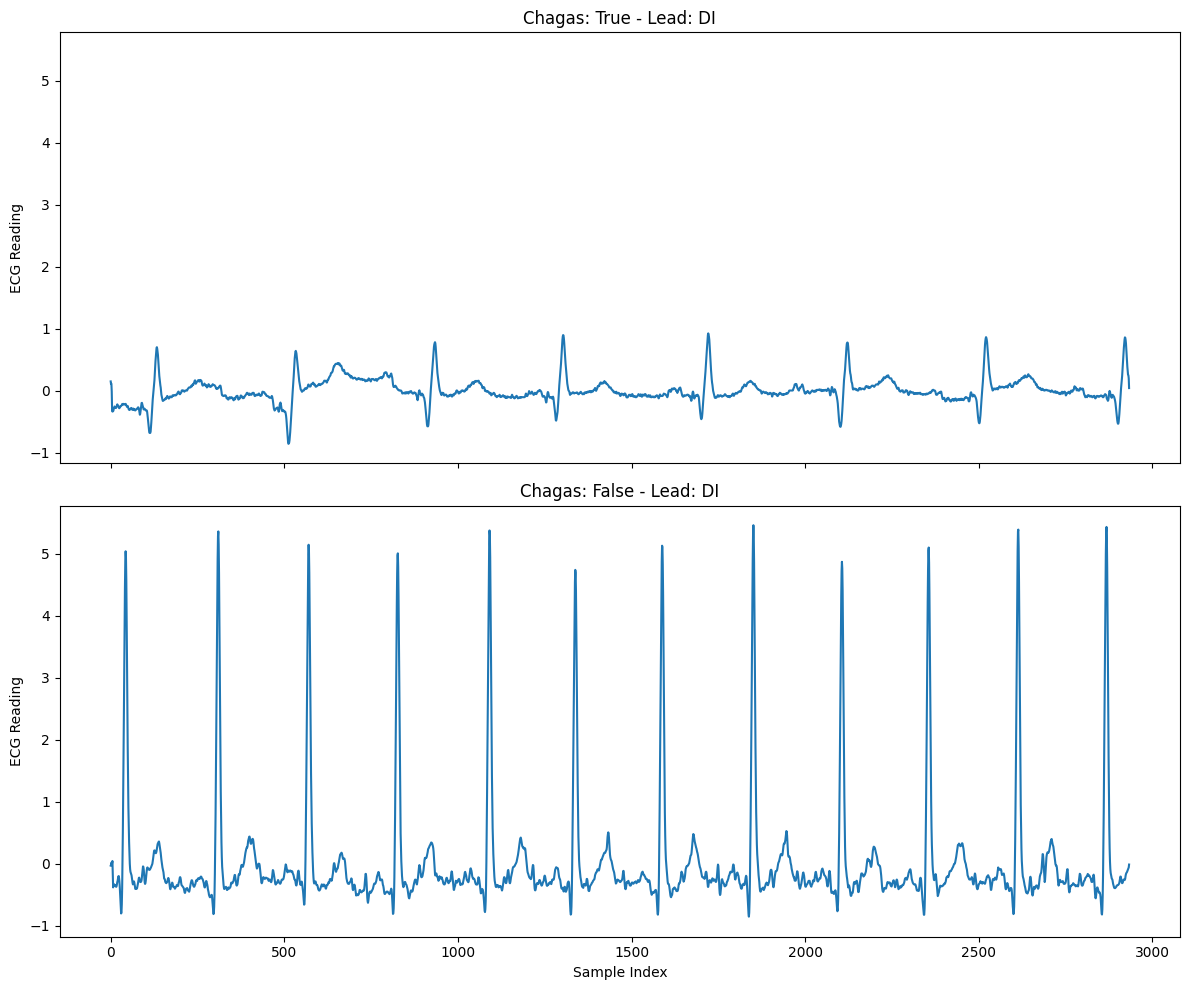

In [55]:
# Filter the DataFrame for True and False chagas readings
true_df = df[df['chagas'] == True]
false_df = df[df['chagas'] == False]

# Ensure both groups have at least one exam
if true_df.empty or false_df.empty:
    print("One of the groups is empty. Please check your DataFrame.")
else:
    # Randomly select one exam from each group
    true_exam = true_df.sample(n=1).iloc[0]
    false_exam = false_df.sample(n=1).iloc[0]

    # Choose the lead to plot
    lead_to_plot = 'DI'  # Randomly select a lead from the available leads
    signal_true = true_exam[lead_to_plot]
    signal_false = false_exam[lead_to_plot]

    # Create subplots for the two ECG readings
    fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True, sharey=True)

    # Plot for the exam with chagas True
    axs[0].plot(signal_true)
    axs[0].set_title(f"Chagas: True - Lead: {lead_to_plot}")
    axs[0].set_ylabel("ECG Reading")

    # Plot for the exam with chagas False
    axs[1].plot(signal_false)
    axs[1].set_title(f"Chagas: False - Lead: {lead_to_plot}")
    axs[1].set_xlabel("Sample Index")
    axs[1].set_ylabel("ECG Reading")

    plt.tight_layout()
    plt.show()

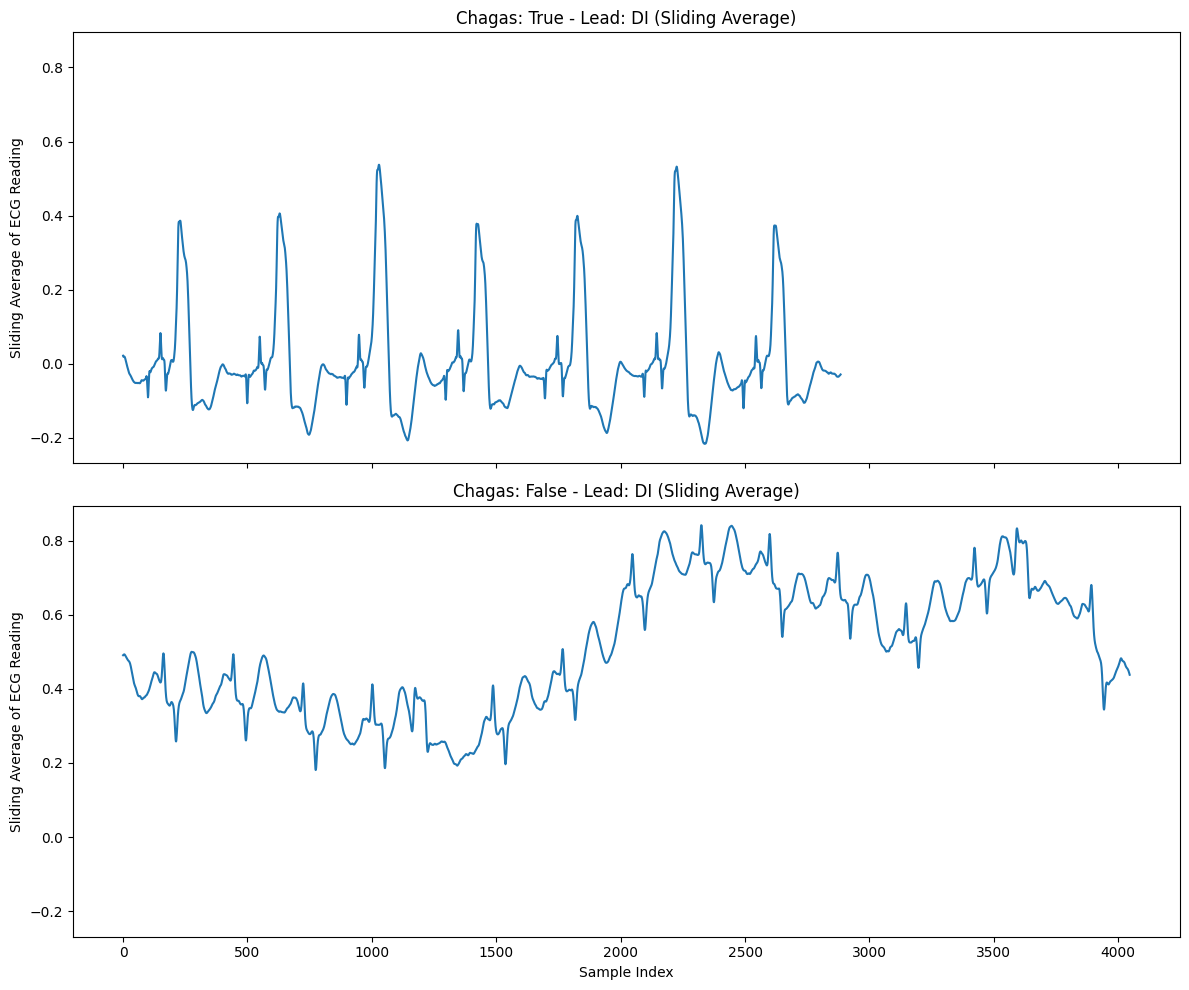

In [48]:
# Filter the DataFrame for True and False chagas readings
true_df = df[df['chagas'] == True]
false_df = df[df['chagas'] == False]

# Ensure both groups have at least one exam
if true_df.empty or false_df.empty:
    print("One of the groups is empty. Please check your DataFrame.")
else:
    # Randomly select one exam from each group
    true_exam = true_df.sample(n=1).iloc[0]
    false_exam = false_df.sample(n=1).iloc[0]

    # Choose the lead to plot
    lead_to_plot = 'DI'  # Randomly select a lead from the available leads
    signal_true = true_exam[lead_to_plot]
    signal_false = false_exam[lead_to_plot]

    # Define the window size for the sliding average
    window_size = 50  # Adjust as needed

    # Compute the sliding averages
    sliding_avg_true = compute_sliding_average(signal_true, window_size)
    sliding_avg_false = compute_sliding_average(signal_false, window_size)

    # Create subplots for the two ECG sliding averages
    fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True, sharey=True)

    # Plot for the exam with chagas True
    axs[0].plot(sliding_avg_true)
    axs[0].set_title(f"Chagas: True - Lead: {lead_to_plot} (Sliding Average)")
    axs[0].set_ylabel("Sliding Average of ECG Reading")

    # Plot for the exam with chagas False
    axs[1].plot(sliding_avg_false)
    axs[1].set_title(f"Chagas: False - Lead: {lead_to_plot} (Sliding Average)")
    axs[1].set_xlabel("Sample Index")
    axs[1].set_ylabel("Sliding Average of ECG Reading")

    plt.tight_layout()
    plt.show()

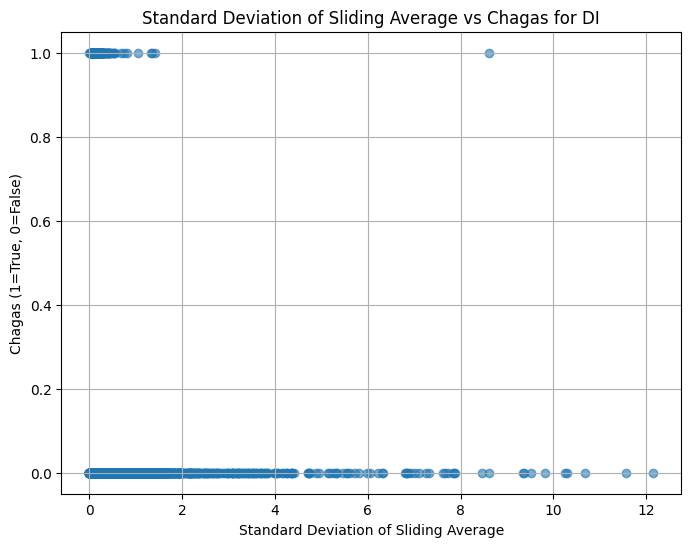

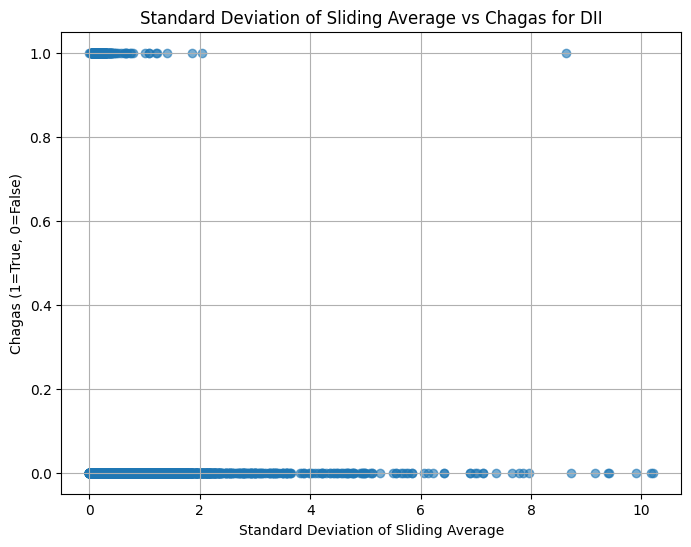

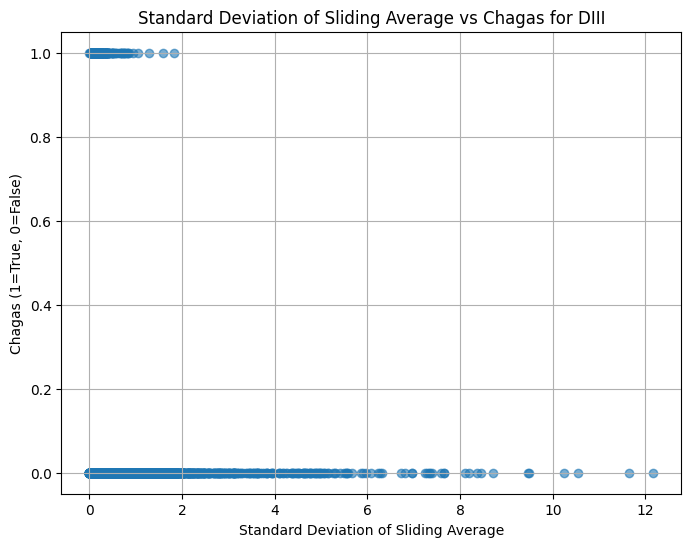

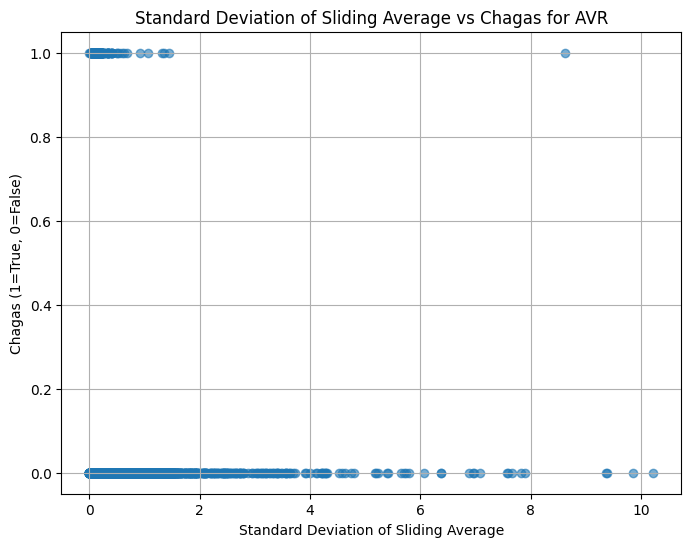

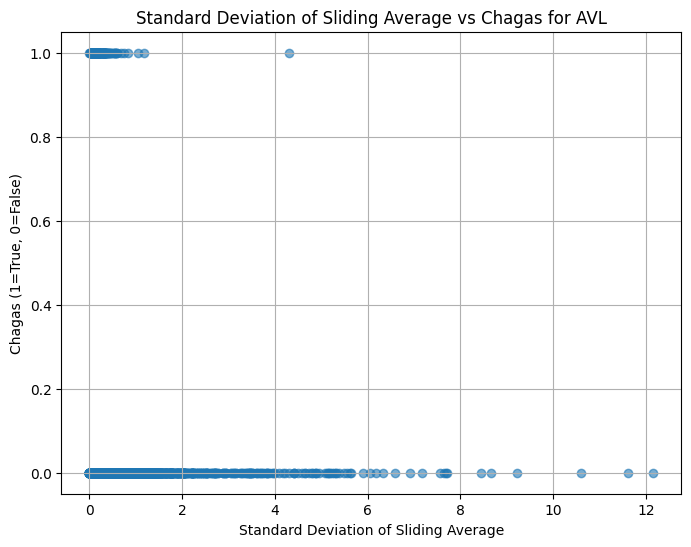

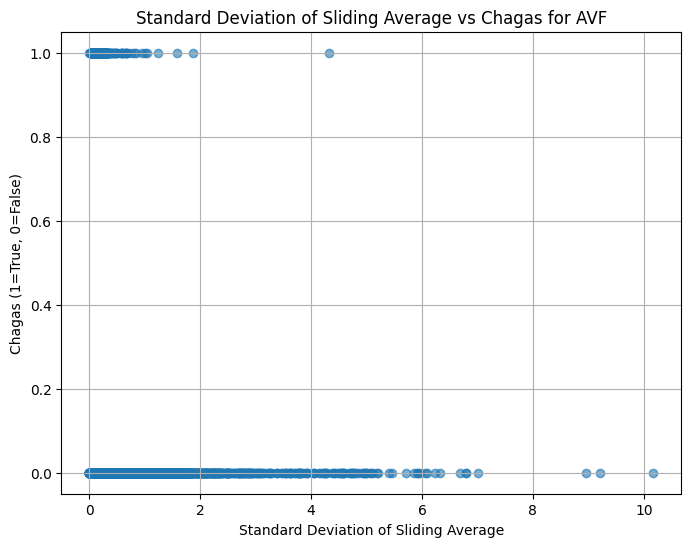

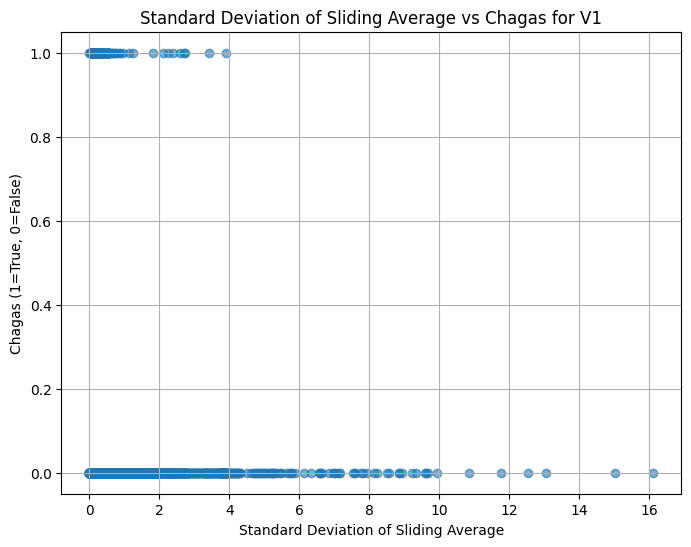

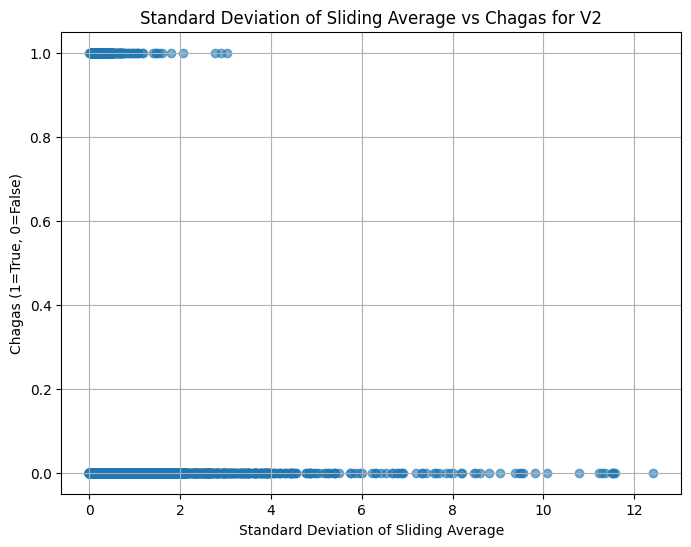

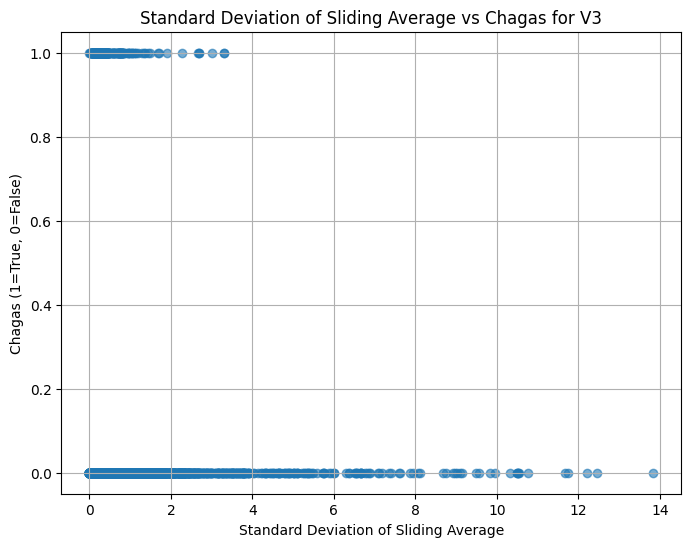

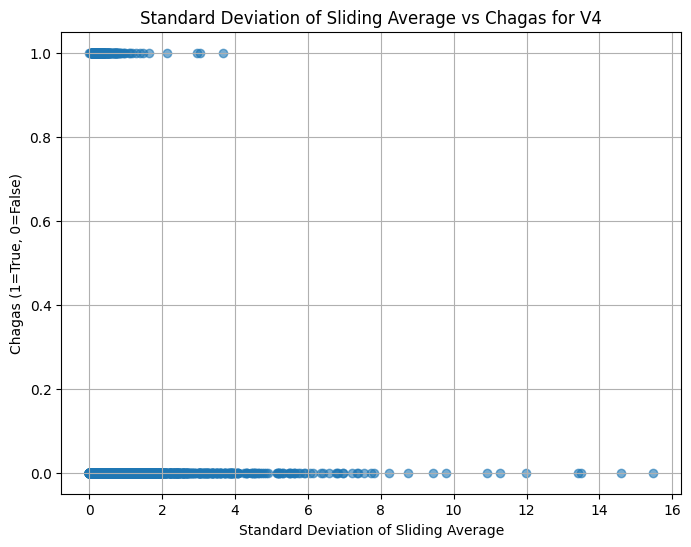

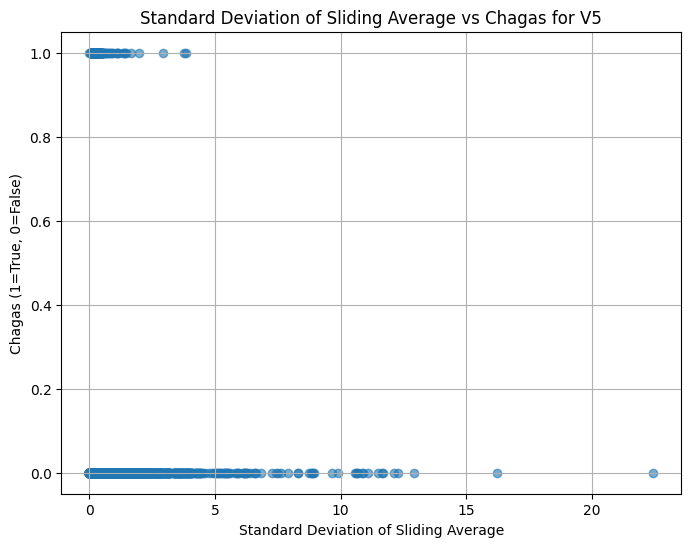

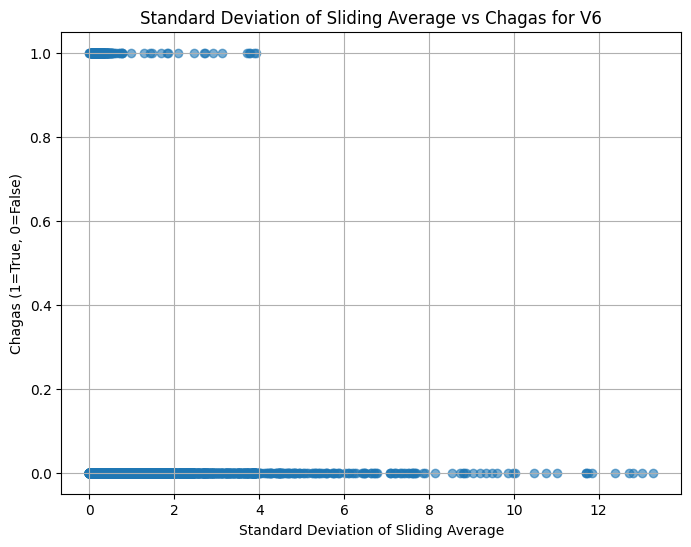

In [49]:
def compute_sliding_average(signal, window_size):
    """
    Compute the sliding average of a 1D array with a specified window size.

    Parameters:
    signal (numpy.ndarray): Input array of ECG readings.
    window_size (int): Window size for the sliding average.

    Returns:
    numpy.ndarray: Array of sliding averages.
    """
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

def plot_std_of_sliding_avg_vs_chagas(df, leads, window_size):
    """
    Plot the standard deviation of the sliding average of each lead against the chagas variable.

    Parameters:
    df (pandas.DataFrame): DataFrame containing ECG data and chagas labels.
    leads (list): List of lead names to process.
    window_size (int): Window size for computing the sliding average.
    """
    # Initialize a list to store the results
    results = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        chagas_value = 1 if row['chagas'] else 0
        for lead in leads:
            signal = row[lead]
            sliding_avg = compute_sliding_average(signal, window_size)
            std_dev = np.std(sliding_avg)
            results.append({'lead': lead, 'std_dev': std_dev, 'chagas': chagas_value})

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Plotting
    for lead in leads:
        lead_data = results_df[results_df['lead'] == lead]
        plt.figure(figsize=(8, 6))
        plt.scatter(lead_data['std_dev'], lead_data['chagas'], alpha=0.6)
        plt.title(f'Standard Deviation of Sliding Average vs Chagas for {lead}')
        plt.xlabel('Standard Deviation of Sliding Average')
        plt.ylabel('Chagas (1=True, 0=False)')
        plt.grid(True)
        plt.show()

# Example usage:
# Assuming 'df' is your DataFrame and 'lead_names' is a list of the 12 lead names
window_size = 50  # Define the window size for the sliding average
plot_std_of_sliding_avg_vs_chagas(df, lead_names, window_size)

In [53]:
# Count the occurrences of True and False in the 'chagas' column
chagas_counts = df['chagas'].value_counts()

# Display the results
print(f"Total 'True' chagas results: {chagas_counts.get(True, 0)}")
print(f"Total 'False' chagas results: {chagas_counts.get(False, 0)}")

Total 'True' chagas results: 403
Total 'False' chagas results: 19536


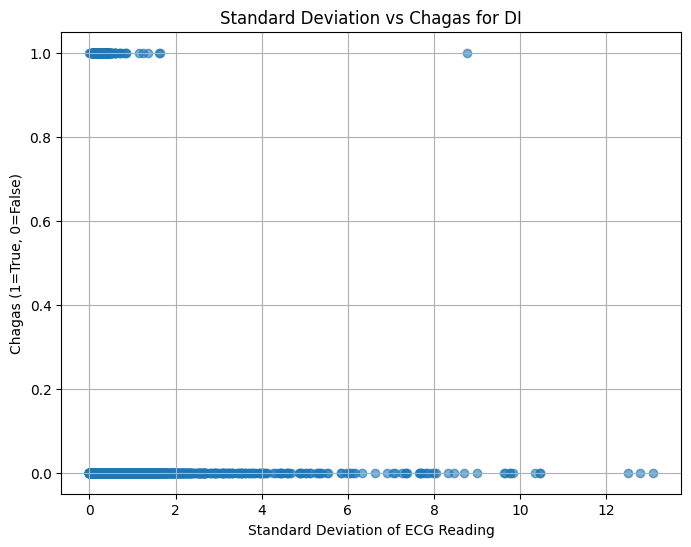

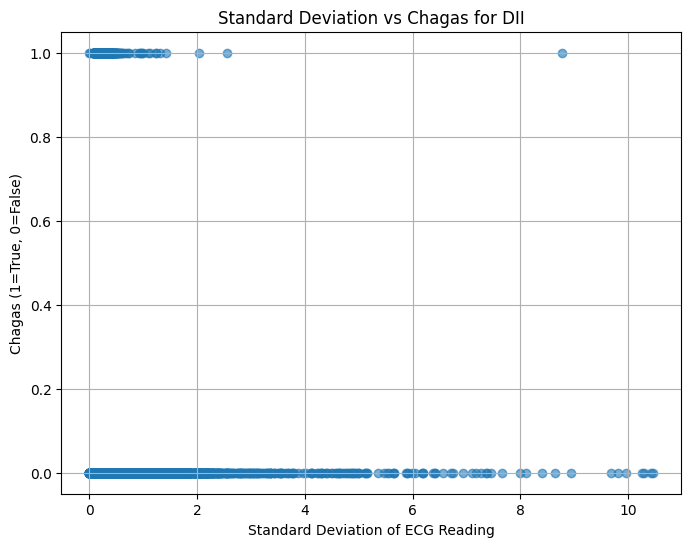

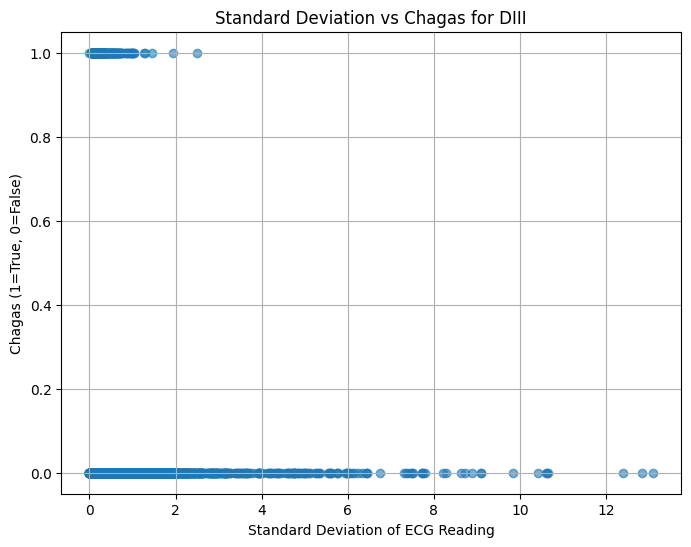

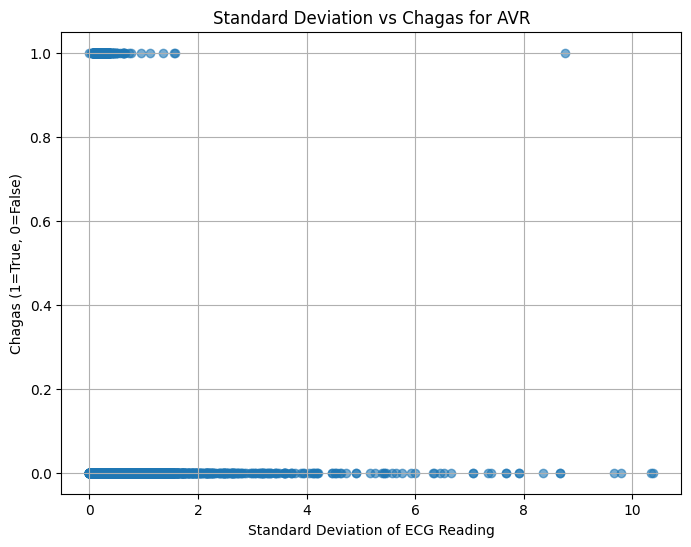

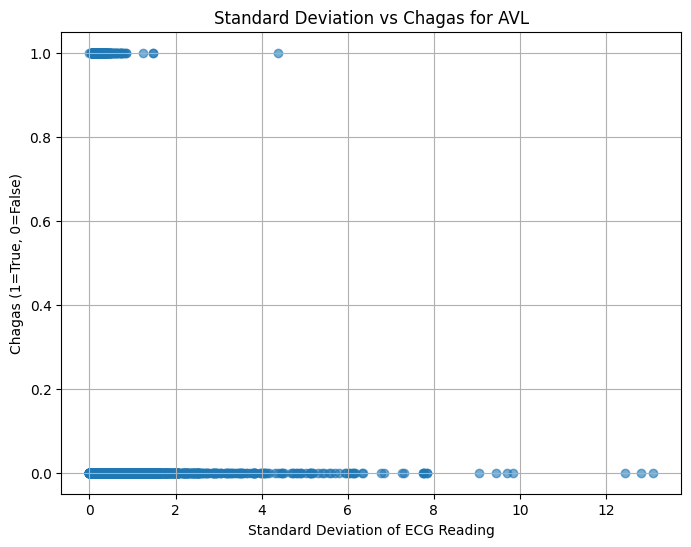

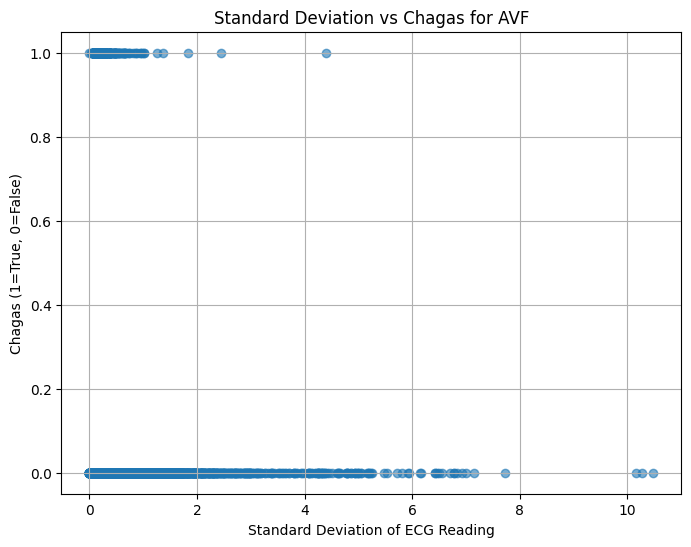

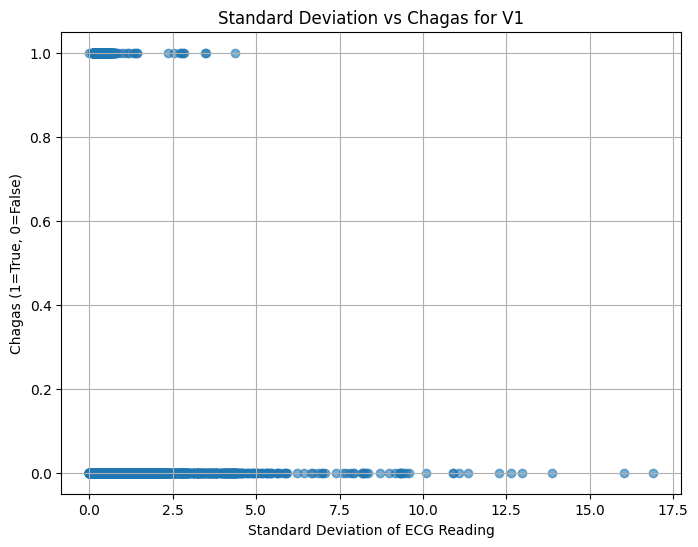

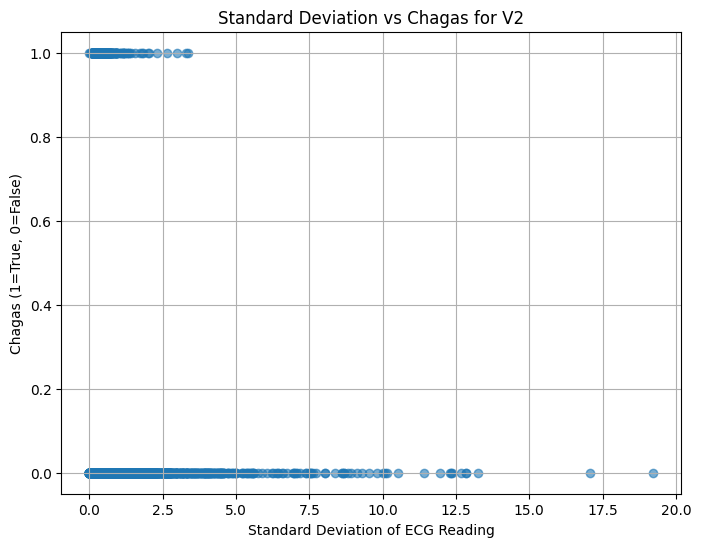

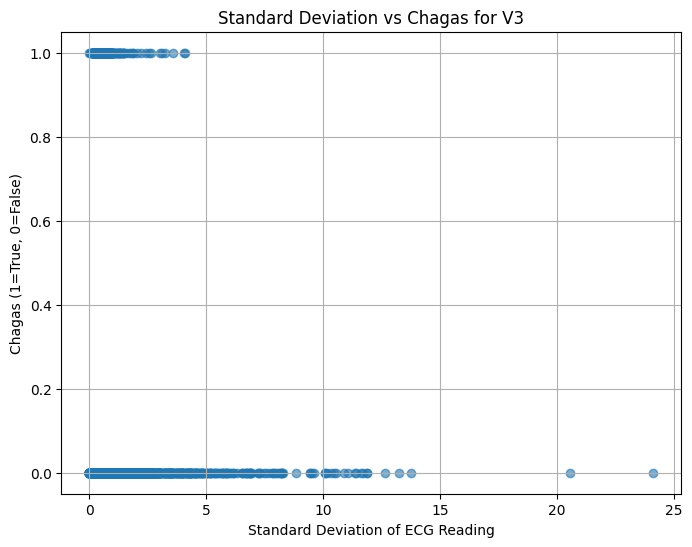

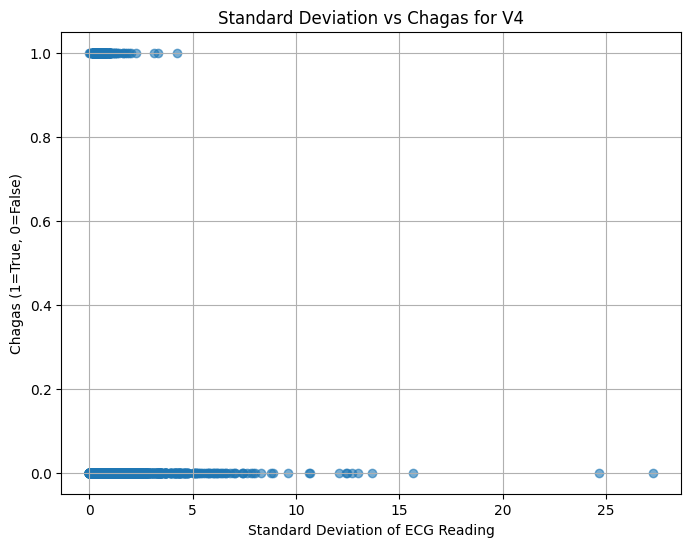

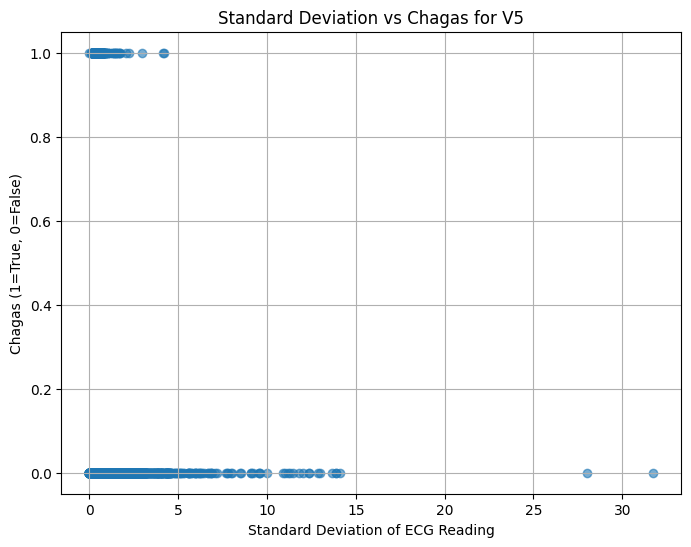

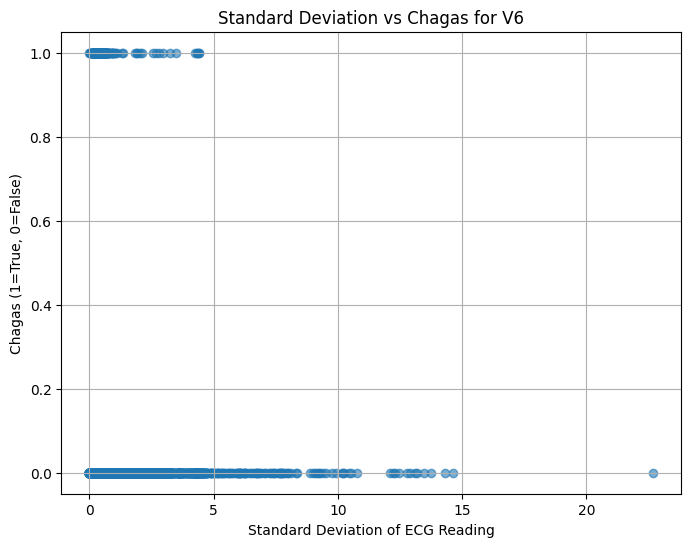

In [54]:
def plot_std_vs_chagas(df, leads):
    """
    Plot the standard deviation of each lead's ECG readings against the chagas classification.

    Parameters:
    df (pandas.DataFrame): DataFrame containing ECG data and chagas labels.
    leads (list): List of lead names to process.
    """
    # Initialize a list to store the results
    results = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        chagas_value = 1 if row['chagas'] else 0
        for lead in leads:
            signal = row[lead]
            std_dev = np.std(signal)
            results.append({'lead': lead, 'std_dev': std_dev, 'chagas': chagas_value})

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Plotting
    for lead in leads:
        lead_data = results_df[results_df['lead'] == lead]
        plt.figure(figsize=(8, 6))
        plt.scatter(lead_data['std_dev'], lead_data['chagas'], alpha=0.6)
        plt.title(f'Standard Deviation vs Chagas for {lead}')
        plt.xlabel('Standard Deviation of ECG Reading')
        plt.ylabel('Chagas (1=True, 0=False)')
        plt.grid(True)
        plt.show()

# Example usage:
# Assuming 'df' is your DataFrame and 'lead_names' is a list of the lead names
plot_std_vs_chagas(df, lead_names)